# Sentiment Analysis on Movie Reviews using SVMs with SGD Classifier with Hinge Loss

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

<b> Data Source: <b> https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

### Attribute Information: 

1. Phrase Id
2. Sentiment Id
3. Phrase
4. Sentiment

#### Objective:  

Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.

#### While pre-processing the original dataset we have taken into consideration the following points. 

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 3 or 4.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 0 or 1.
3. We will ignore the reviews for the time being which has a Score rating of 2. Because 2 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. We will train our final model using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative.

## 1.Reading Raw Data 

In [2]:
data = pd.read_csv('data.tsv.zip', delimiter='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
final_data=data
final_data['SentimentPolarity'] = final_data['Sentiment'].apply(lambda x : 'Positive' if x > 2 else 'Negative')
final_data['Class_Labels'] = final_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
final_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,SentimentPolarity,Class_Labels
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,0
1,2,1,A series of escapades demonstrating the adage ...,2,Negative,0
2,3,1,A series,2,Negative,0
3,4,1,A,2,Negative,0
4,5,1,series,2,Negative,0


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews'}>

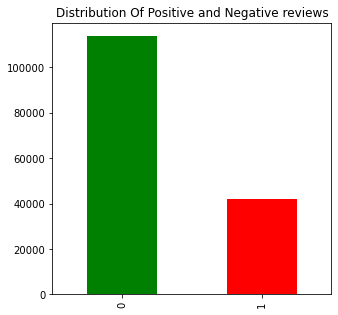

In [4]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews',figsize=(5,5))

## [2]. Preprocessing 

### [2.1]. Preprocessing Review 

Our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [5]:
#Printing some random reviews.
sent_1 = final_data['Phrase'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Phrase'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Phrase'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Phrase'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Phrase'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Review Polarity: Negative
to avoid
Review Polarity: Negative
convolutions
Review Polarity: Negative
pointless extremes
Review Polarity: Negative
Dignified CEO 's meet at a rustic retreat and pee against a tree .
Review Polarity: Negative


In [6]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)


print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . 

to avoid 

convolutions 

pointless extremes 

Dignified CEO 's meet at a rustic retreat and pee against a tree . 



In [7]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

to avoid

convolutions

pointless extremes

Dignified CEO 's meet at a rustic retreat and pee against a tree .



In [8]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [9]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


In [10]:
'''Data Cleaning Stage.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [11]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

100%|████████████████████████████████████████████████████████████████████████| 10221/10221 [00:00<00:00, 601793.75it/s]


Text(0, 0.5, 'Number of Words')

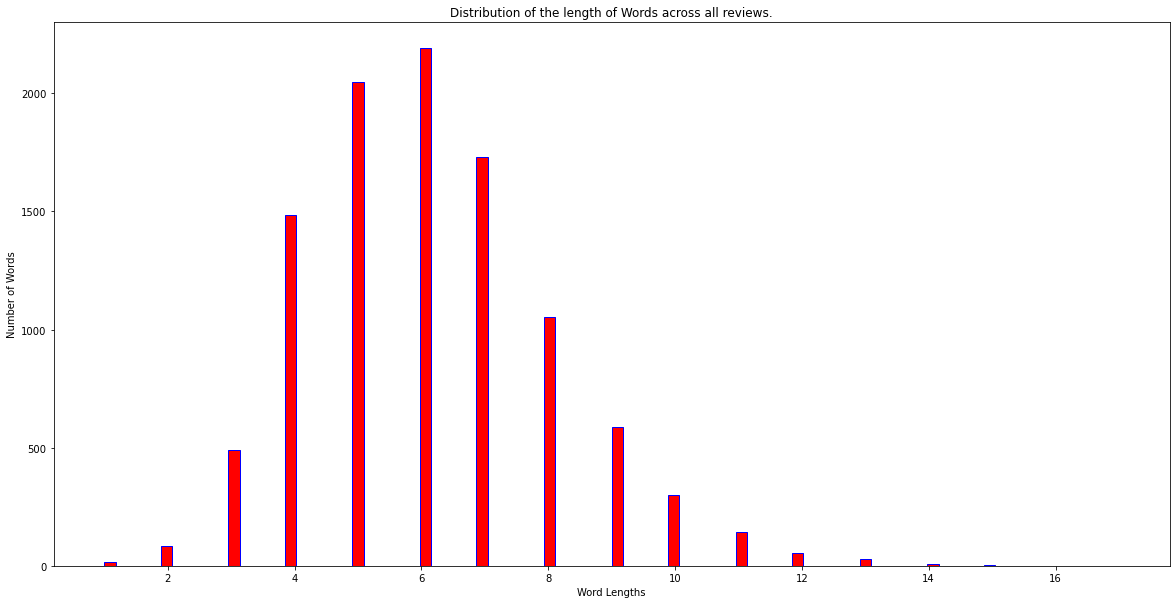

In [12]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram: 

We can see that most stemmed words present in the reviews has lengths between 3 and 10. Words which has length greater than 13 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 13.

In [13]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|████████████████████████████████████████████████████████████████████████| 156060/156060 [00:39<00:00, 3970.43it/s]


The length of the data corpus is : 156060


## [3]. Featurization 

In [14]:
processed_db=final_data
#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['CleanedText'].iloc[0:93635,] ; y_train = processed_db['Class_Labels'].iloc[0:93635,]
X_test = processed_db['CleanedText'].iloc[93635:112362,] ; y_test = processed_db['Class_Labels'].iloc[93635:112362,]
X_calib = processed_db['CleanedText'].iloc[112362:156060,] ; y_calib = processed_db['Class_Labels'].iloc[112362:156060,]

processed_db.head()

,PhraseId,SentenceId,Phrase,Sentiment,SentimentPolarity,Class_Labels,CleanedText
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,0,seri escapad demonstr adag good goos also good...
1,2,1,A series of escapades demonstrating the adage ...,2,Negative,0,seri escapad demonstr adag good goos
2,3,1,A series,2,Negative,0,seri
3,4,1,A,2,Negative,0,
4,5,1,series,2,Negative,0,seri


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews in 150K datapoints.'}>

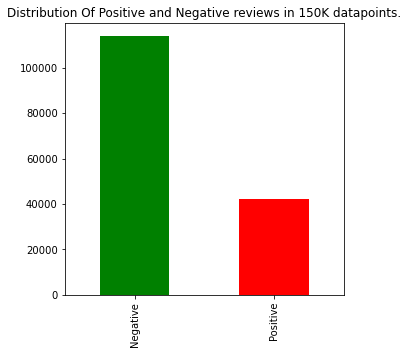

In [15]:
#Display distribution of Postive and Negative reviews.
processed_db["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 150K datapoints.',figsize=(5,5))

### [3.1] BAG OF WORDS 

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms. The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.

In [16]:
#Initializing the BOW constructor
cv_object = CountVectorizer(dtype='float')
cv_object.fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)
X_calib_vectors = cv_object.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BOW.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BOW.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BOW.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BOW.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BOW.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BOW.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['affabl', 'affair', 'affect', 'affection', 'affirm', 'affleck', 'afflict', 'affluent', 'afford', 'aficionado']

Creating the BOW vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BOW vectorizer  (93635, 7961)
The shape of our test BOW vectorizer  (18727, 7961)
The number of unique words  7961


### [3.2] Bi-Grams and n-Grams 

In [17]:

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#Initializing the Bi-Gram constructor
cv_object = CountVectorizer(ngram_range=(1,2), dtype='float')             #min_df=10: ignore terms that have a document frequency strictly lower than 10.
cv_object.fit(X_train)                                                                                  #max_features=50000: top 50000 features

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the Bi-Gram matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the Bi-Gram vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bi grams train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['abus film', 'abus inner', 'abus piti', 'abus veer', 'abysm', 'abysm hannib', 'abyss', 'academ', 'academ lower', 'academi']

Creating the Bi-Gram vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (93635, 45522)
The shape of our test BiGram vectorizer  (18727, 45522)
The number of unique words  45522


### [3.3] TF-IDF 

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review. For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector.

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.

In [18]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), dtype='float').fit(X_train) #min_df=10: ignore terms that have a document frequency strictly lower than 10.
                                                                                                           #max_features=50000: top 50000 features
#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words including both unigrams and bigrams. ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['abus film', 'abus inner', 'abus piti', 'abus veer', 'abysm', 'abysm hannib', 'abyss', 'academ', 'academ lower', 'academi']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (93635, 45522)
The shape of our test BiGram vectorizer  (18727, 45522)
The number of unique words including both unigrams and bigrams.  45522


### [3.4] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [3.4.1] Avg W2V 

In this model we convert each word present in a review to vectors. For each sentence we will compute the average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will convert each word to a vector, sum them up and divide by the total number of words (N) present in that particular sentence. So our final vector will look like (1/N) * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [19]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=4) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(50) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


print("The shape of our Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('X_calib_W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

The size of the Word2Vec text corpus :  93635


100%|██████████████████████████████████████████████████████████████████████████| 43698/43698 [00:10<00:00, 4013.14it/s]


The shape of our Avg Word2Vec train vectorizer  (93635, 50)
The shape of our Avg Word2Vec test vectorizer  (18727, 50)
The shape of our Avg Word2Vec calibration vectorizer  (43698, 50)


#### [3.4.2] TFIDF weighted W2v

In this model we convert each word present in a review to vectors. For each sentence we will compute the tf-idf average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will compute the tf-idf for each word in a review for all reviews. Lets say the corresponding tf-idfs are {t1,t2,t3,t4,t5,t6......tN}. We will convert each word to a vector, sum them up and divide by the summation of tf-idf vectors for all words present in that particular sentence. So our final vector will look like [1/(t1+t2+t3+t4+t5+t6+ ..... +tN)] * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [20]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=4)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(50) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)
                                           
#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|██████████████████████████████████████████████████████████████████████████| 43698/43698 [00:30<00:00, 1425.81it/s]


The shape of our TF-IDF Avg Word2Vec train vectorizer  (93635, 50)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (18727, 50)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (43698, 50)


## Applying SVM 

The below block of code contains all the common functions that are used for the evaluation of the models.

In [21]:
#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization, hyp):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C or alpha values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i][hyp])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs Hyperparameter values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('AUC Scores vs Hyperparameter Values ')
    plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
    plt.ylabel('(AUC Scores)')
    plt.legend()
    plt.show()
    
    if(regularization=='l2'):
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:40] , auc_train[0:40], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:40] , auc_test[0:40], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    else:
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:25] , auc_train[0:25], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:25] , auc_test[0:25], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    
    return (optimal_hp)

#Fit this model with the best value of hyperparameter obtained.
def performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and train the model.
    classifier = best_clf
    classifier.fit(X_train, y_train)

    #Using CalibratedClassifierCV to caliberate the model and plot the ROC AUC Curve.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)
    
    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)
    
    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix ")
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_SVM.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return calibrated_clf

### [4.1] Linear SVM 

In [22]:
def get_GridSearchCV_estimator_linear_SVM(regularization, vectorizationType, X_train, y_train):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUsing {} regularization for {} model!".format(regularization, vectorizationType))
    print("*****************************************************")
    from sklearn.model_selection import TimeSeriesSplit
    from datetime import datetime as dt
    st=dt.now()
    
    alpha = np.logspace(-4,4,50)
    tuned_parameters = [{'alpha': alpha}] #alpha values used for cross validation
    n_folds = 10
    #cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    
    base_estimator = SGDClassifier(loss='hinge',penalty=regularization, random_state=0) #Linear SVM: SGD Classifier using hinge loss.
    gsearch_cv = GridSearchCV(estimator=base_estimator, param_grid=tuned_parameters, cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True)
    gsearch_cv.fit(X_train, y_train)
    
    print("\nTime taken to perform grid search:",dt.now()-st)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_hp=plot_errors(gsearch_cv, regularization, "alpha") #We pass the string 'alpha' to make plot_error() to use the same value for the hyperparameter name.
    
    return  (gsearch_cv,optimal_hp) 

def linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. ".format(regularization.upper()))
    print("********************************************************************************")
    gsearch_cv, optimal_hp = get_GridSearchCV_estimator_linear_SVM(regularization, vectorizationType, X_train, y_train)
    best_clf = gsearch_cv.best_estimator_
    
    trained_classifier = performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp)
    
    return (trained_classifier)

#Why can we do feature importance using only linear SVMs and not poly or rbf?
'''Weights are asigned to the features (coefficients in the primal problem). This is only available in the case of linear kernel. In linear SVM the resulting 
separating plane is in the same space as your input features. Therefore its coefficients can be viewed as weights of the input's "dimensions". In other kernels, 
the separating plane exists in another space - a result of kernel transformation of the original space. Its coefficients are not directly related to the input space. 
In fact, for the rbf kernel the transformed space is infinite-dimensional (you can get a starting point on this on Wikipedia [https://en.wikipedia.org/wiki/Support-vector_machine#Definition] of course)'''

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(trained_clf, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    svm = trained_clf.base_estimator
    top_pos_features = (-svm.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (svm.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:50])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:50])
    
    print('The top 50 most important features from the positive class is: \n')
    print(top_pos_features)
    
    print('\nThe top 50 most important features from the negative class is: \n')
    print(top_neg_features)

### [4.1.1] Applying Linear SVM on BOW + L1 Regularization 

Shape of the train data matrix:  (93635, 7961)
Shape of the test data matrix:  (18727, 7961)
Shape of the calibration data matrix:  (43698, 7961)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for BOW-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:12:26.592591
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0020235896477251557, penalty='l1', random_state=0)
Best Score for l1 regularization :  0.7149483676625513
The optimal value of C using l1 regularization is : 0.0020235896477251557


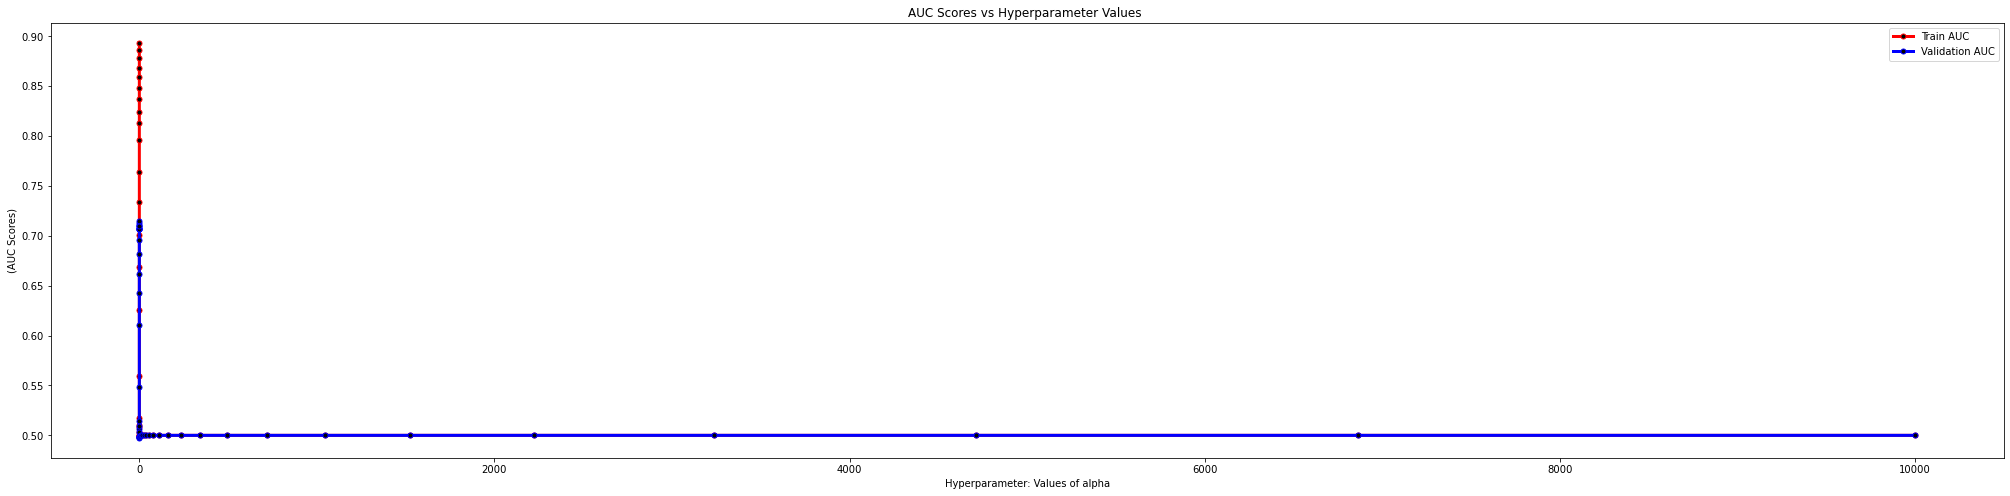

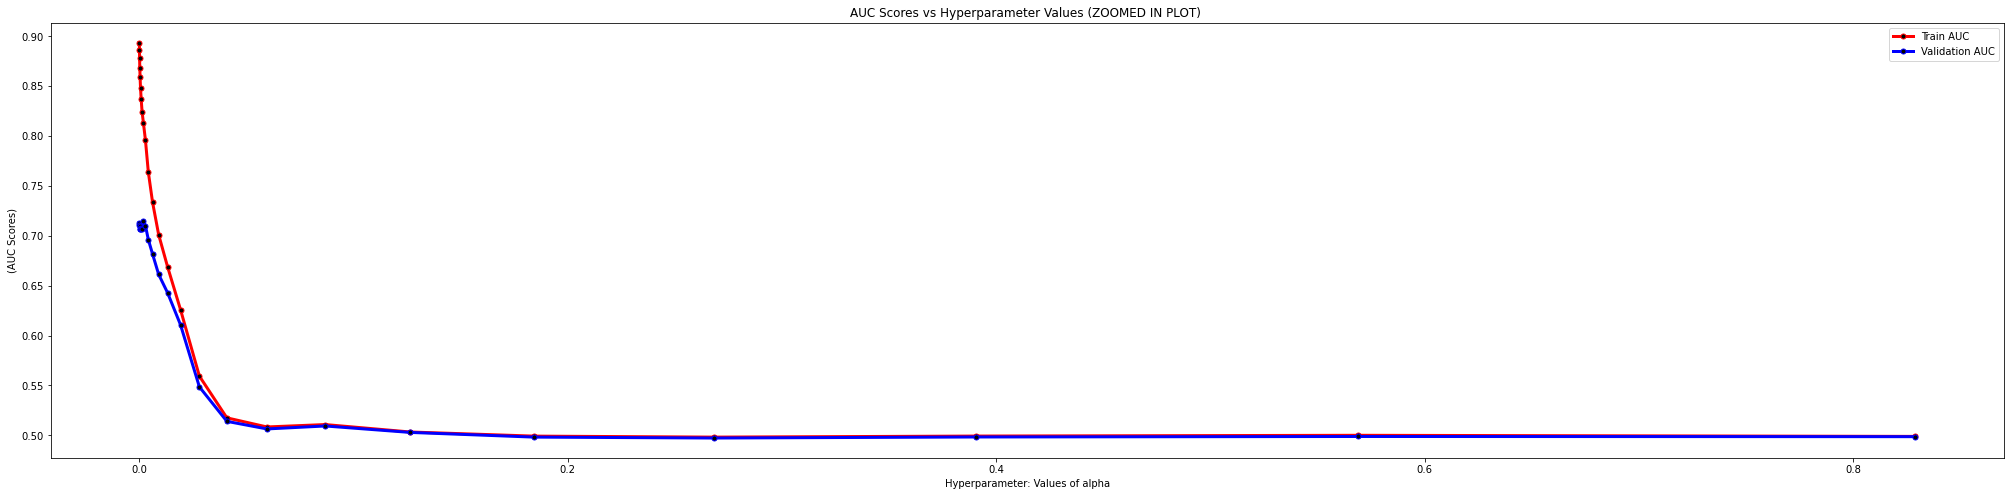


'''PERFORMANCE EVALUATION for BOW-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l1 regularization is 14690
Accuracy of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 78.4428899449992 %
Precision of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.6128
Recall of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.5125
F1 score of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.5582
AUC of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.7495

Clasification report 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86     13751
           1       0.61      0.51      0.56      4976

    accuracy                           0.78     18727
   macro avg       0.72      0.70      0.71     18727
weighted avg       

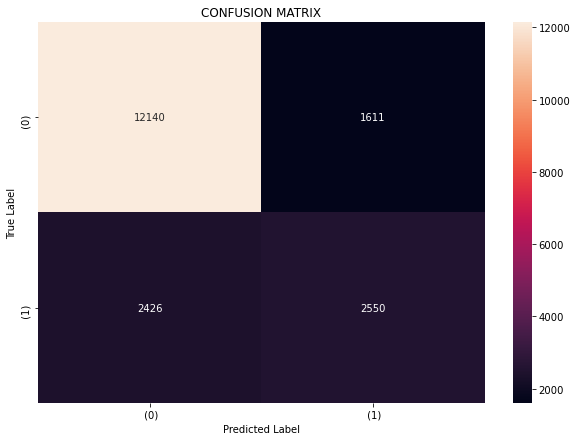

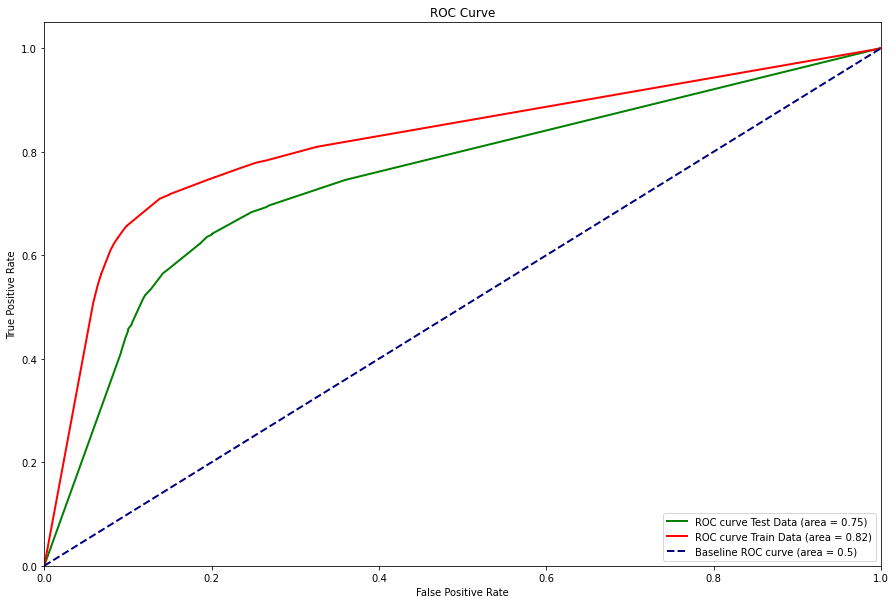

In [23]:
#Load the BOW Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_BOW.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_BOW.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_BOW.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_BOW.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_BOW.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_BOW.pkl', 'rb') as file:
    y_calib = pickle.load(file)   

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_BOW_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "BOW-LINEAR-SVM")

In [24]:
#Get top positive and negative features.
top_features(trained_classifier_BOW_LSVC_L1, cv_object)

The top 50 most important features from the positive class is: 

['begin minor' 'clamor anoth' 'comedi swing' 'bulli husband'
 'chabrol becom' 'best screen' 'castro predomin' 'betray'
 'budget pinocchio' 'audac subject' 'associ choos' 'charact viewer'
 'break code' 'architect pop' 'come road' 'caffein' 'boyz' 'abus veer'
 'adrift bentley' 'addit funni' 'anoth cartoon' 'along hail' 'best'
 'audienc side' 'bold imag' 'crap like' 'bizarr keep' 'behind cutesi'
 'beauti desir' 'comput generat' 'art scare' 'chronicl not'
 'although lack' 'close though' 'cold loud' 'capabl charm' 'compar friday'
 'blockbust like' 'abund' 'aim poetri' 'cockey' 'build multi'
 'better book' 'can corn' 'ambiti naturalist' 'cheapo margarita'
 'courtesi' 'comedi scotland' 'charm well' 'anim backdrop']

The top 50 most important features from the negative class is: 

['collis tawdri' 'children rediscov' 'cardoso' 'claus plot' 'abl creep'
 'actor exercis' 'actor spout' 'aloof unreach' 'alreadi done'
 'certain degre' 

### [4.1.2] Applying Linear SVM on BOW + L2 Regularization 


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for BOW-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:01:12.409473
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.0062505519252739694, random_state=0)
Best Score for l2 regularization :  0.7923548638394605
The optimal value of C using l1 regularization is : 0.0062505519252739694


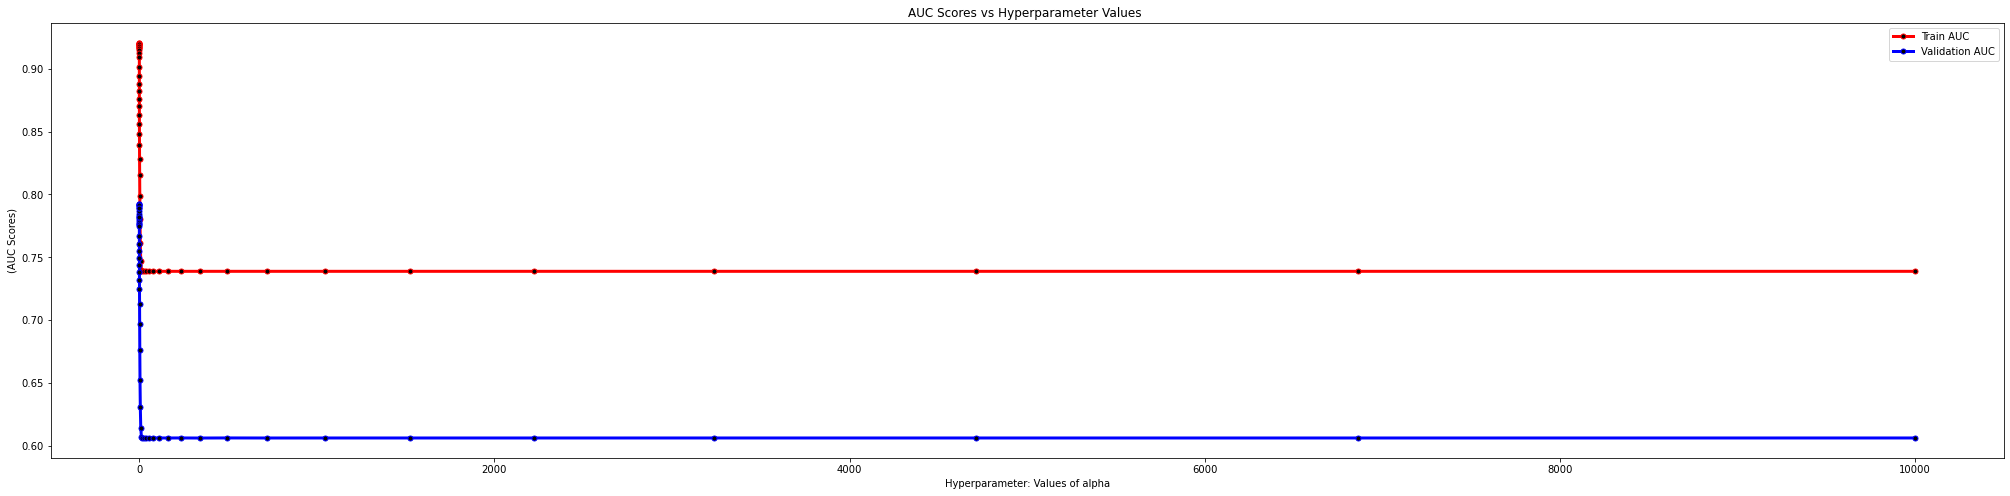

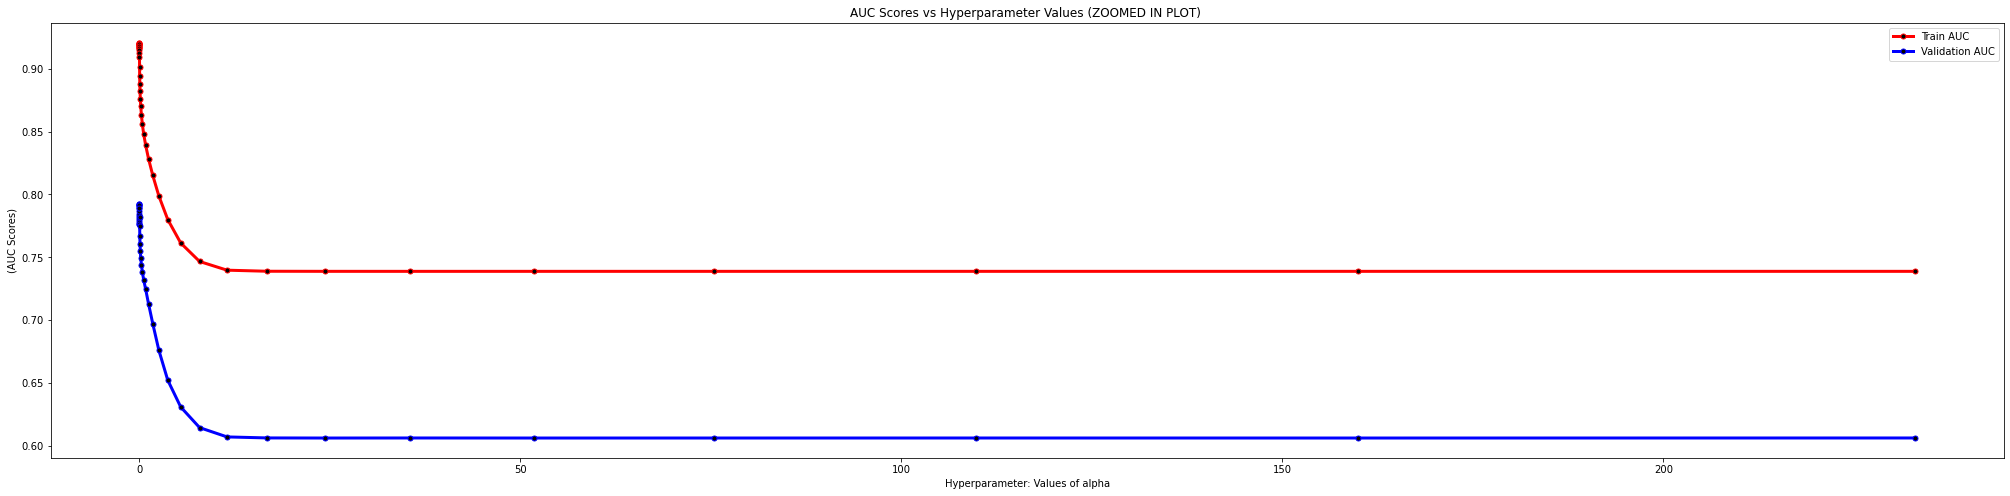


'''PERFORMANCE EVALUATION for BOW-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l2 regularization is 15193
Accuracy of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 81.12885139103967 %
Precision of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.6876
Recall of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.5311
F1 score of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.5993
AUC of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.8117

Clasification report 
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     13751
           1       0.69      0.53      0.60      4976

    accuracy                           0.81     18727
   macro avg       0.77      0.72      0.74     18727
weighted avg      

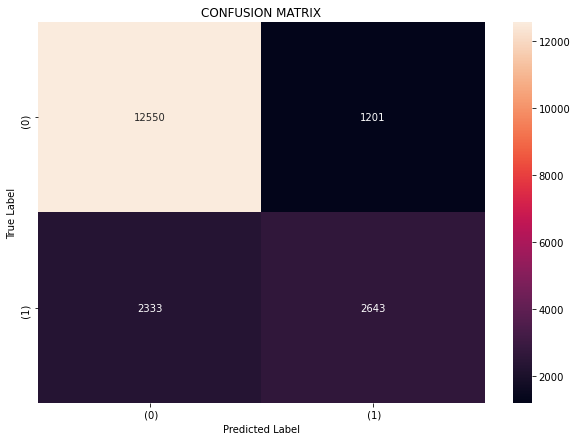

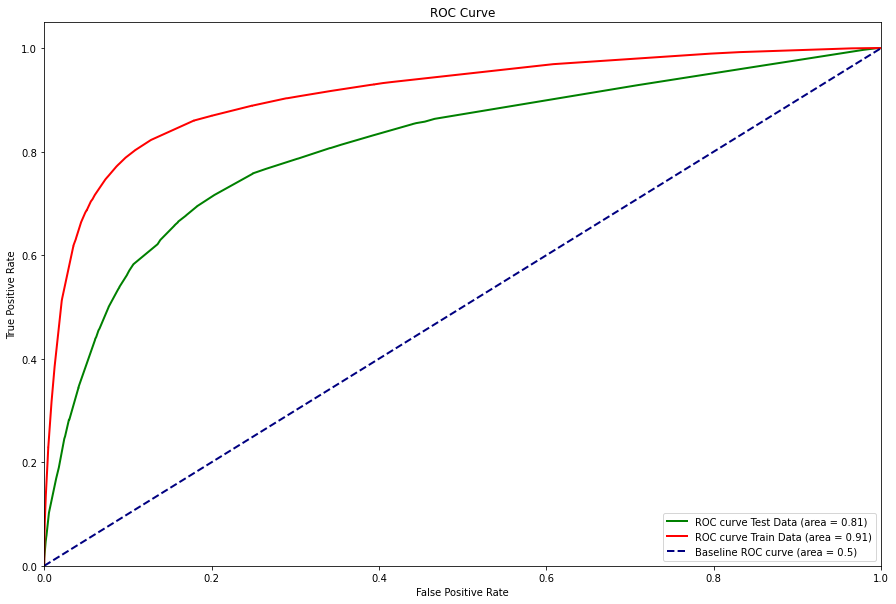

In [25]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_BOW_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "BOW-LINEAR-SVM")

In [26]:
#Get top positive and negative features.
top_features(trained_classifier_BOW_LSVC_L2, cv_object)

The top 50 most important features from the positive class is: 

['bear wast' 'box special' 'adult way' 'barber feel' 'beauti record'
 'attempt someth' 'could keep' 'admir reconstruct' 'attent film'
 'barb slap' 'also unorigin' 'away almost' 'central plot' 'case christian'
 'berkley' 'amount earnest' 'comic film' 'act miscalcul' 'bit naughti'
 'catch fire' 'close recent' 'catch may' 'attempt kind' 'appeal manic'
 'charm tale' 'bit far' 'commit mockumentari' 'comedi nice' 'crack crass'
 'belli' 'backdrop well' 'bride prove' 'biter stand' 'clutch sarandon'
 'bidder walk' 'america especi' 'beat austin' 'chemic perfect'
 'crafti intellig' 'built' 'air everi' 'compens' 'byte inform' 'also win'
 'best love' 'ackerman creat' 'astound number' 'charli kaufman' 'balzac'
 'coupl snipe']

The top 50 most important features from the negative class is: 

['calib' 'bodi find' 'ararat went' 'colosseum' 'clip film' 'cahil'
 'citi rrb' 'agent decod' 'contain substanc' 'book script' 'actual tell'
 'bit a

### [4.1.3] Applying Linear SVM on TFIDF + L1 Regularization, 

Shape of the train data matrix:  (93635, 45522)
Shape of the test data matrix:  (18727, 45522)
Shape of the calibration data matrix:  (43698, 45522)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:16:17.444538
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.004291934260128779, penalty='l1', random_state=0)
Best Score for l1 regularization :  0.6657399003850386
The optimal value of C using l1 regularization is : 0.004291934260128779


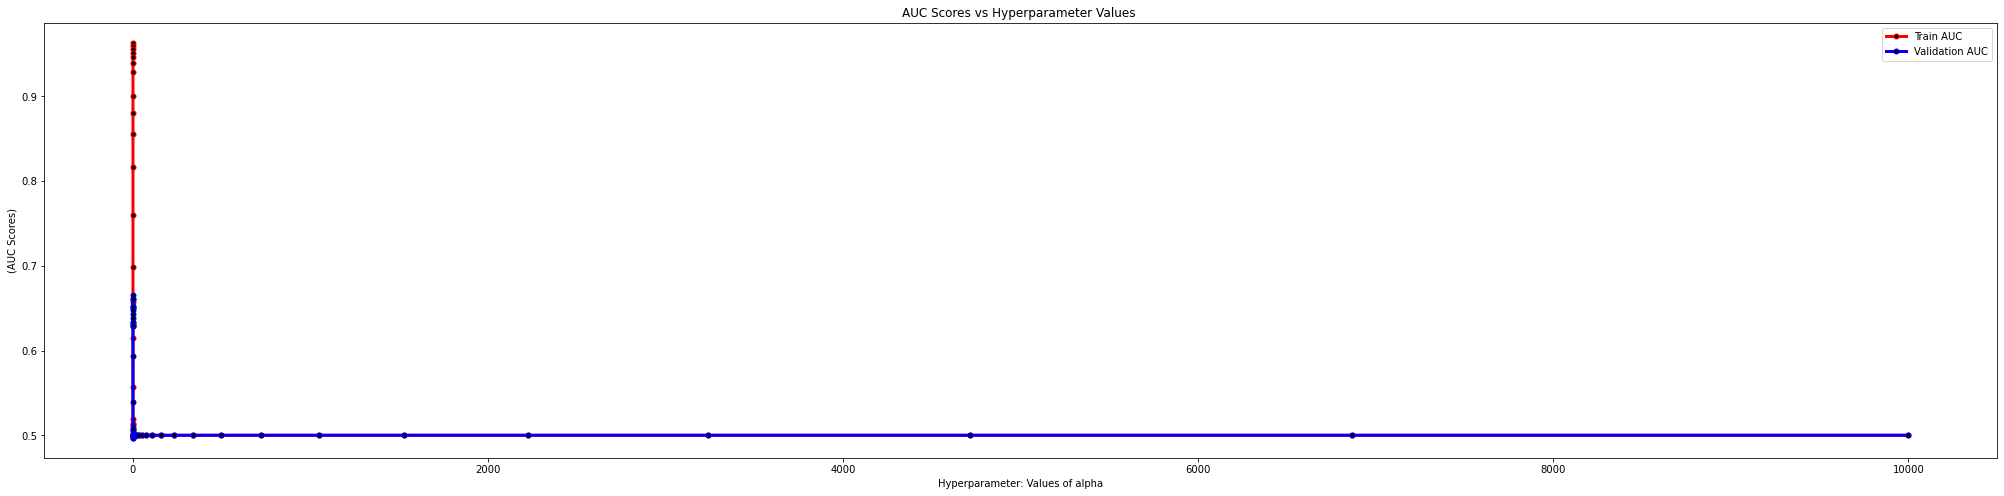

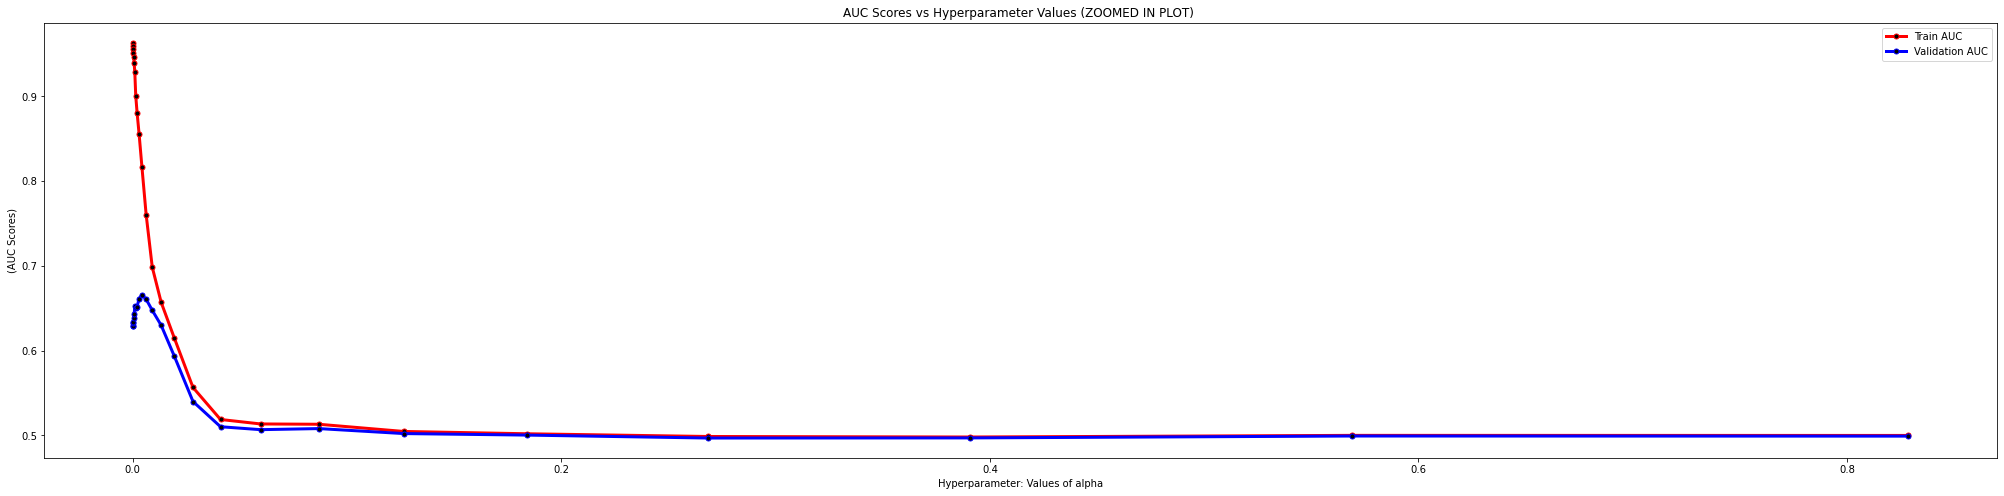


'''PERFORMANCE EVALUATION for TFIDF-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l1 regularization is 14772
Accuracy of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 78.8807603994233 %
Precision of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.6424
Recall of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.4628
F1 score of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.538
AUC of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.7178

Clasification report 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     13751
           1       0.64      0.46      0.54      4976

    accuracy                           0.79     18727
   macro avg       0.73      0.68      0.70     18727
weighted

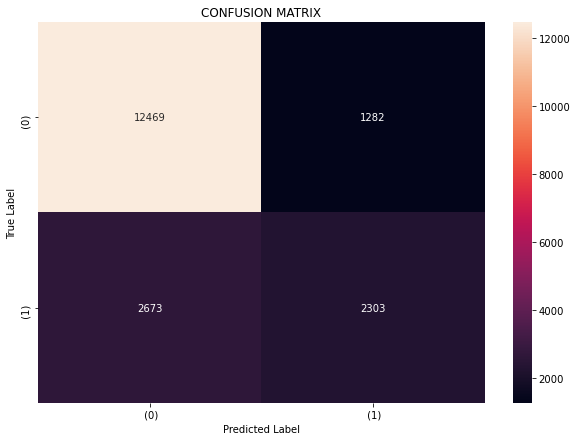

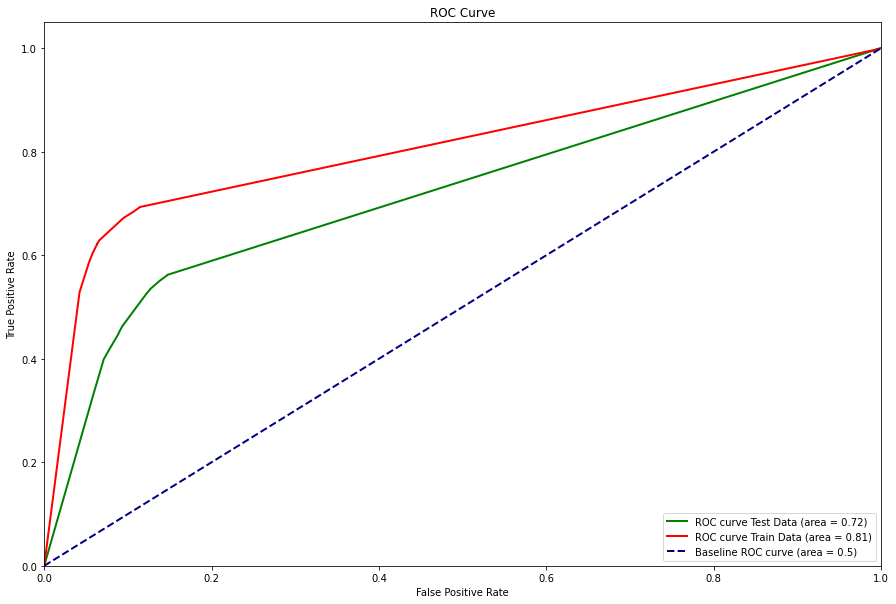

In [27]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "TFIDF-LINEAR-SVM")

In [28]:
#Get top positive and negative features.
top_features(trained_classifier_TFIDF_LSVC_L1, tf_idf_obj)

The top 50 most important features from the positive class is: 

['halo benefit' 'still updat' 'stylish thriller' 'connect women'
 'thorough engag' 'flash doubl' 'serendip also' 'accomplish rich'
 'predict reassur' 'women one' 'grand scale' 'multipl strand'
 'good measur' 'faith without' 'one span' 'footag stir' 'also remind'
 'rich reson' 'stori appeal' 'manner beauti' 'cross made' 'horn halo'
 'movi often' 'live breath' 'without forc' 'hitchcockian suspens'
 'touch british' 'best advic' 'pivot role' 'respons question'
 'deeper direct' 'sensibl writer' 'not love' 'good fun' 'nobl teacher'
 'engag surpris' 'reson work' 'made mamet' 'breath part' 'sad without'
 'priceless' 'art live' 'astonish pivot' 'sung holiday' 'reveal mean'
 'heist much' 'direct connect' 'interest unfaith' 'song movi' 'ecstasi']

The top 50 most important features from the negative class is: 

['spoiler alert' 'nose instead' 'cours unintent' 'rosa' 'shell game'
 'plot stereotyp' 'health' 'pick nose' 'alert rrb' 'se

### [4.1.4] Applying Linear SVM on TFIDF + L2 Regularization 


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for TFIDF-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:01:37.064032
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.004291934260128779, random_state=0)
Best Score for l2 regularization :  0.741503818043648
The optimal value of C using l1 regularization is : 0.004291934260128779


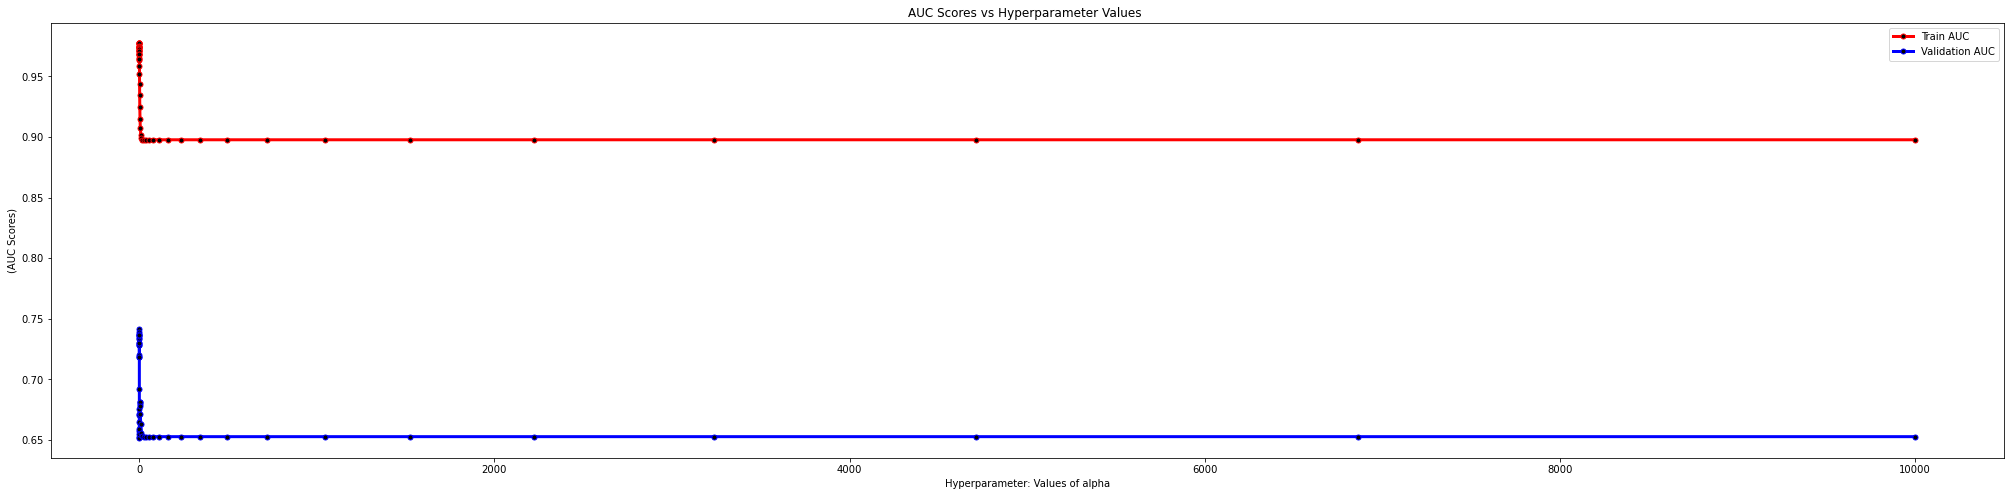

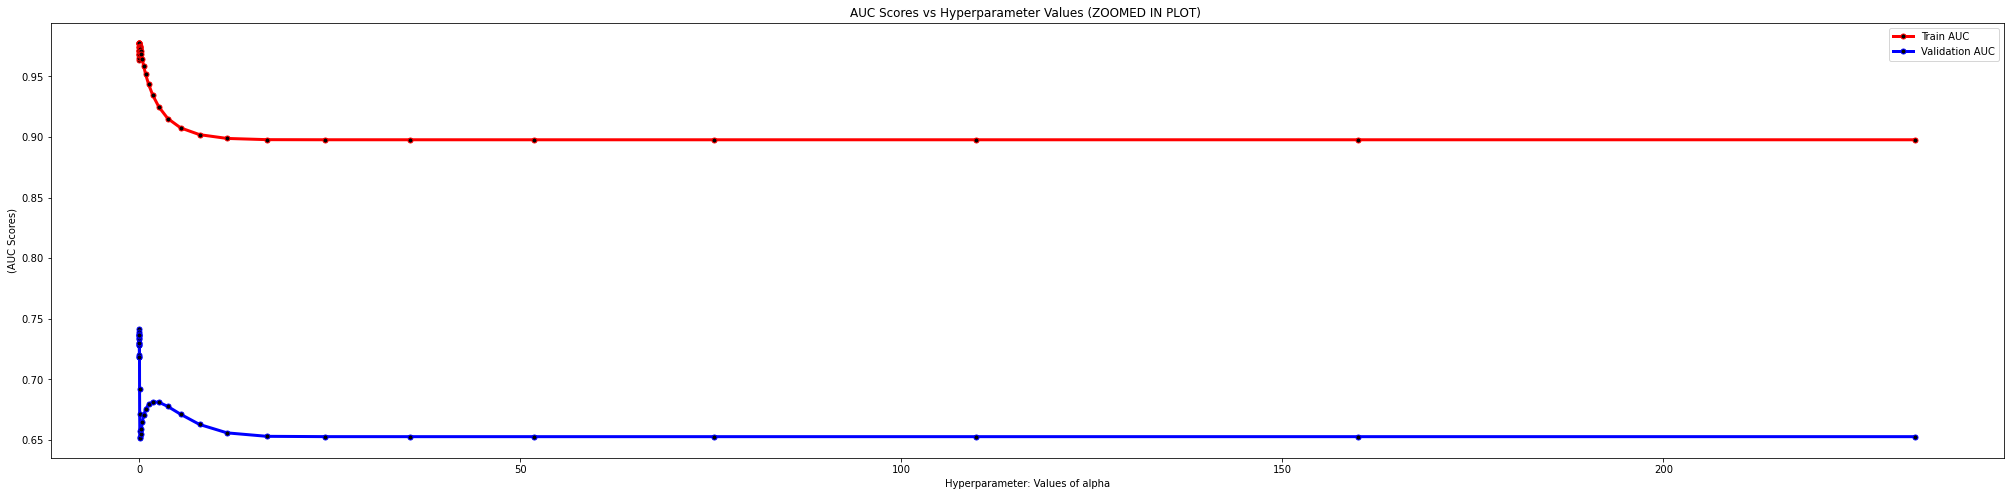


'''PERFORMANCE EVALUATION for TFIDF-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l2 regularization is 14768
Accuracy of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 78.85940086506115 %
Precision of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.6395
Recall of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.4684
F1 score of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.5408
AUC of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.7762

Clasification report 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     13751
           1       0.64      0.47      0.54      4976

    accuracy                           0.79     18727
   macro avg       0.73      0.69      0.70     18727
weight

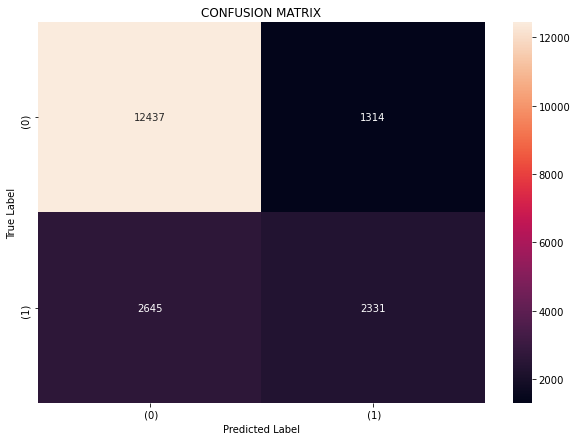

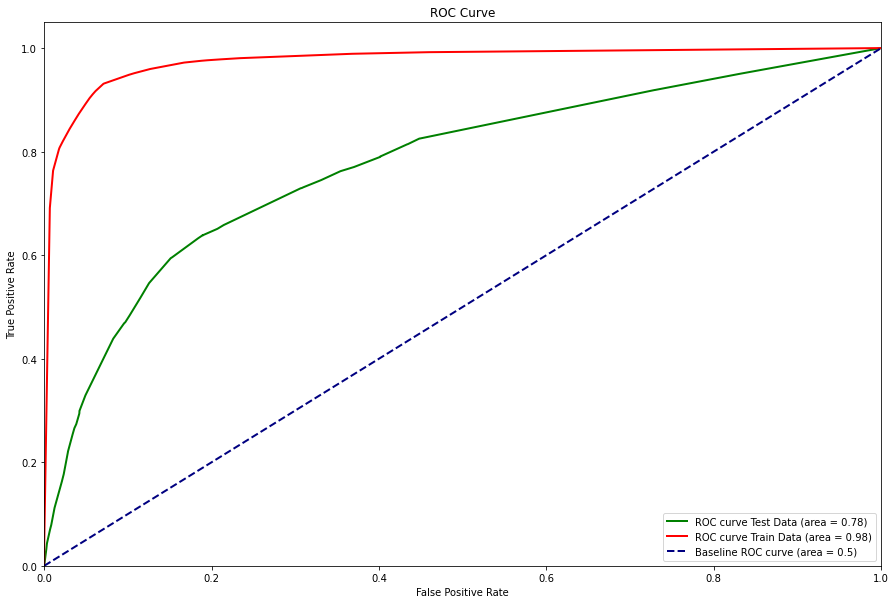

In [29]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "TFIDF-LINEAR-SVM")

In [30]:
#Get top positive and negative features.
top_features(trained_classifier_TFIDF_LSVC_L2, tf_idf_obj)

The top 50 most important features from the positive class is: 

['good' 'well made' 'love' 'deliv promis' 'funni' 'entertain' 'interest'
 'best' 'one not' 'fun' 'movi ever' 'enjoy' 'film well' 'charm' 'origin'
 'not disappoint' 'better' 'great' 'wrench perform' 'intellig' 'laugh'
 'compel' 'beauti shot' 'effect' 'inspir' 'beauti' 'clever' 'amus'
 'also one' 'sweet' 'lush beauti' 'sens movi' 'well establish'
 'enough watch' 'romant' 'film rrb' 'success' 'someth littl' 'imagin'
 'fascin' 'charact express' 'appeal' 'bottom sophist' 'smart' 'talent'
 'fresh' 'impress' 'perfect' 'engag' 'lot time']

The top 50 most important features from the negative class is: 

['bad' 'not alway' 'not think' 'not much' 'short' 'not worth' 'look like'
 'not enough' 'perform consumm' 'not care' 'not come' 'film produc'
 'minor work' 'mention' 'not get' 'chris rock' 'feel' 'four minut'
 'brother' 'rug' 'man singl' 'afterlif lot' 'perform not' 'not entir'
 'not particular' 'cynic documentari' 'not rememb' 'n

### [4.1.5] Applying Linear SVM on AVG W2V + L1 Regularization 

Shape of the train data matrix:  (93635, 50)
Shape of the test data matrix:  (18727, 50)
Shape of the calibration data matrix:  (43698, 50)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:00:56.880484
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.00030888435964774815, penalty='l1', random_state=0)
Best Score for l1 regularization :  0.6626181522981216
The optimal value of C using l1 regularization is : 0.00030888435964774815


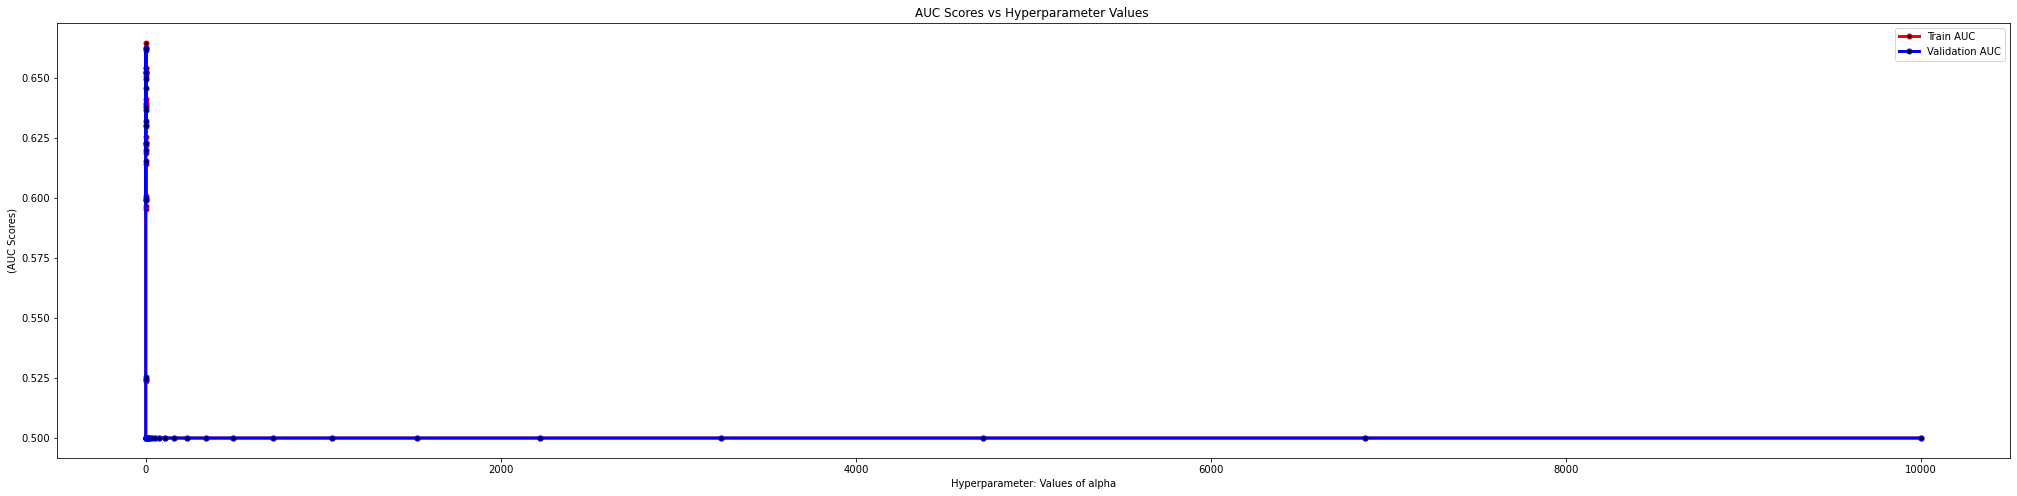

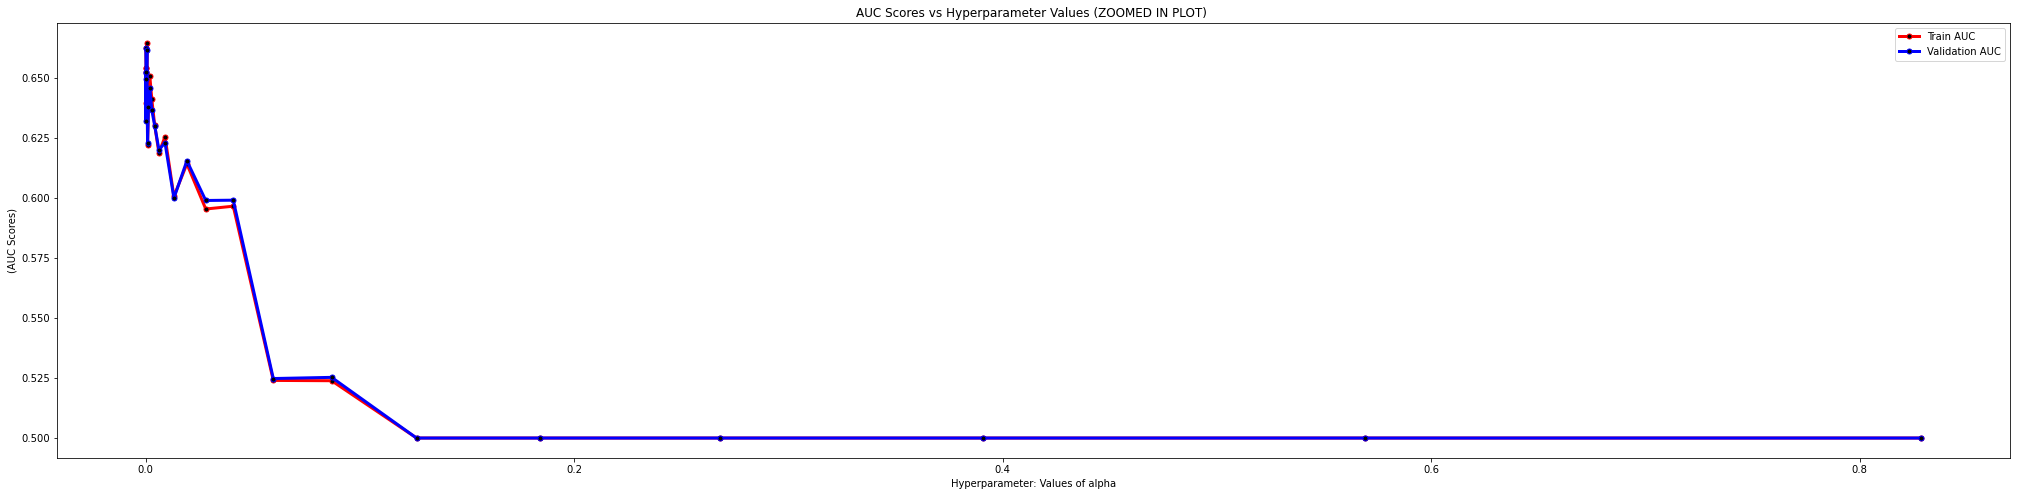


'''PERFORMANCE EVALUATION for W2V-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l1 regularization is 13866
Accuracy of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 74.04282586639611 %
Precision of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.7106
Recall of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.039
F1 score of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.0739
AUC of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.6433

Clasification report 
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     13751
           1       0.71      0.04      0.07      4976

    accuracy                           0.74     18727
   macro avg       0.73      0.52      0.46     18727
weighted avg       

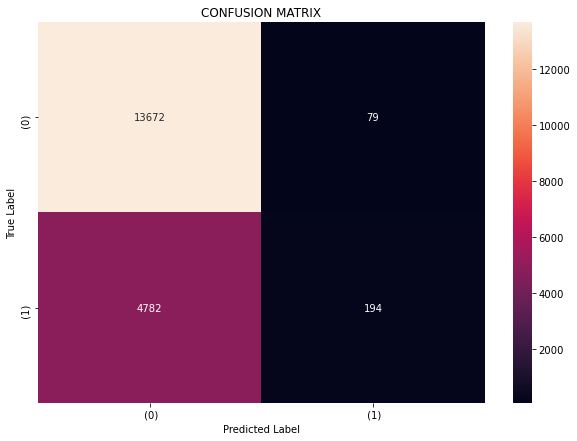

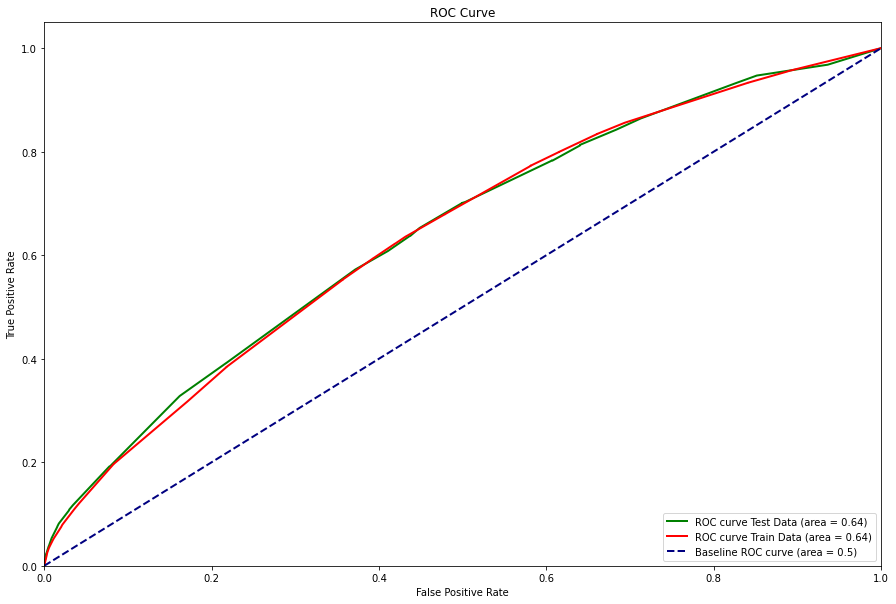

In [31]:
#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "W2V-LINEAR-SVM")

### [4.1.6] Applying Linear SVM on AVG W2V + L2 Regularization


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:00:37.014809
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.18420699693267145, random_state=0)
Best Score for l2 regularization :  0.6719057625502488
The optimal value of C using l1 regularization is : 0.18420699693267145


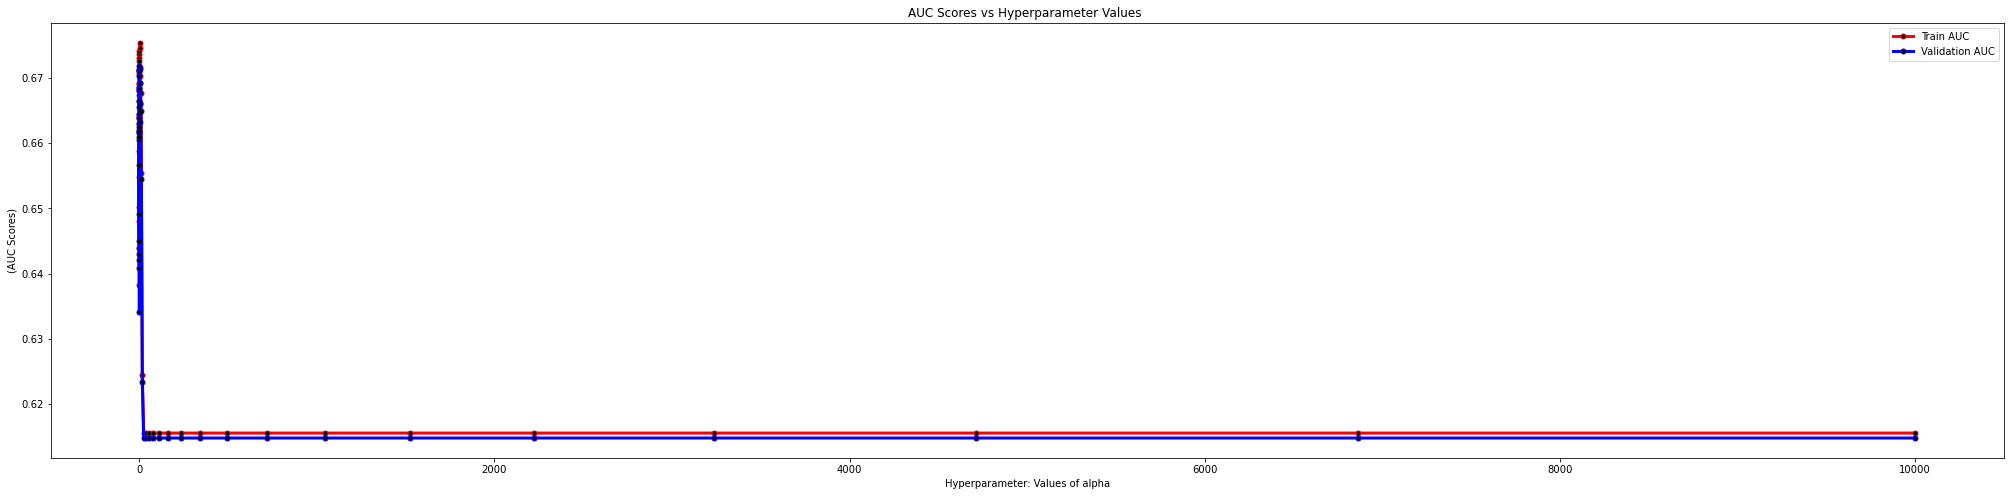

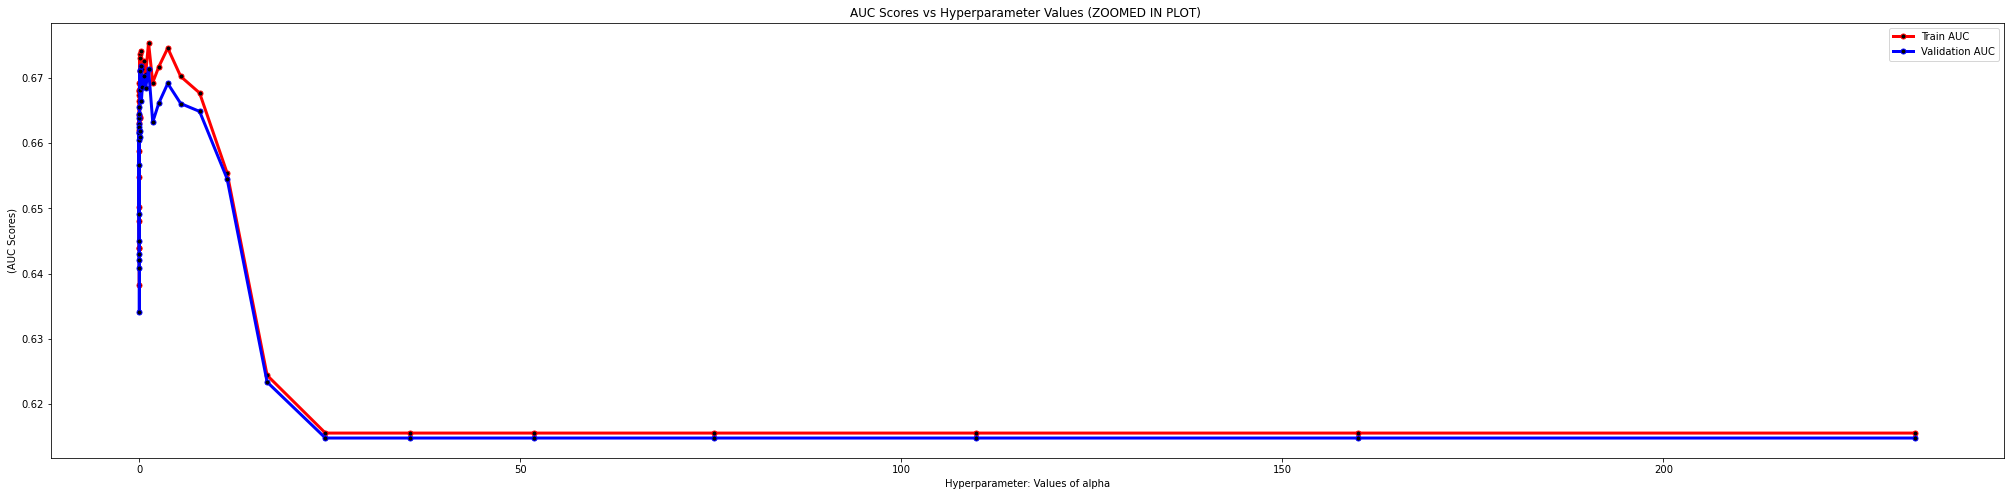


'''PERFORMANCE EVALUATION for W2V-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l2 regularization is 13995
Accuracy of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 74.73167084957548 %
Precision of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.575
Recall of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.1879
F1 score of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.2832
AUC of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.6794

Clasification report 
              precision    recall  f1-score   support

           0       0.76      0.95      0.85     13751
           1       0.58      0.19      0.28      4976

    accuracy                           0.75     18727
   macro avg       0.67      0.57      0.56     18727
weighted avg       

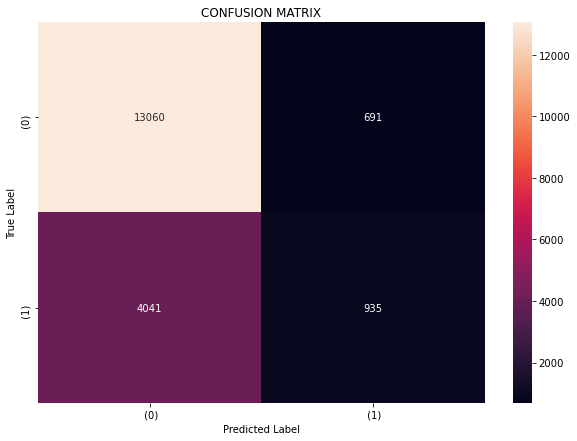

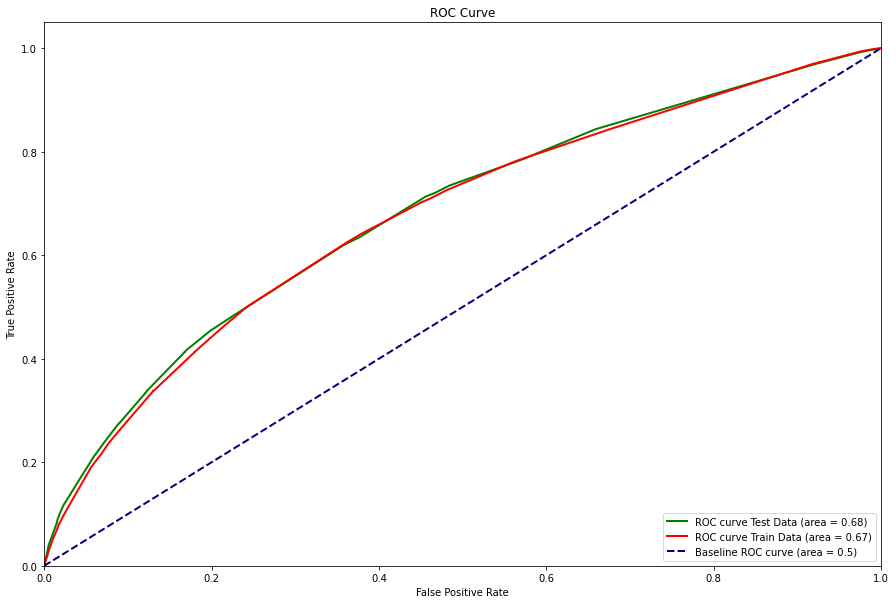

In [32]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "W2V-LINEAR-SVM")

### [4.1.7] Applying Linear SVM on TFIDF W2V + L1 Regularization 

Shape of the train data matrix:  (93635, 50)
Shape of the test data matrix:  (18727, 50)
Shape of the calibration data matrix:  (43698, 50)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:00:55.825214
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0004498432668969444, penalty='l1', random_state=0)
Best Score for l1 regularization :  0.6612354265996533
The optimal value of C using l1 regularization is : 0.0004498432668969444


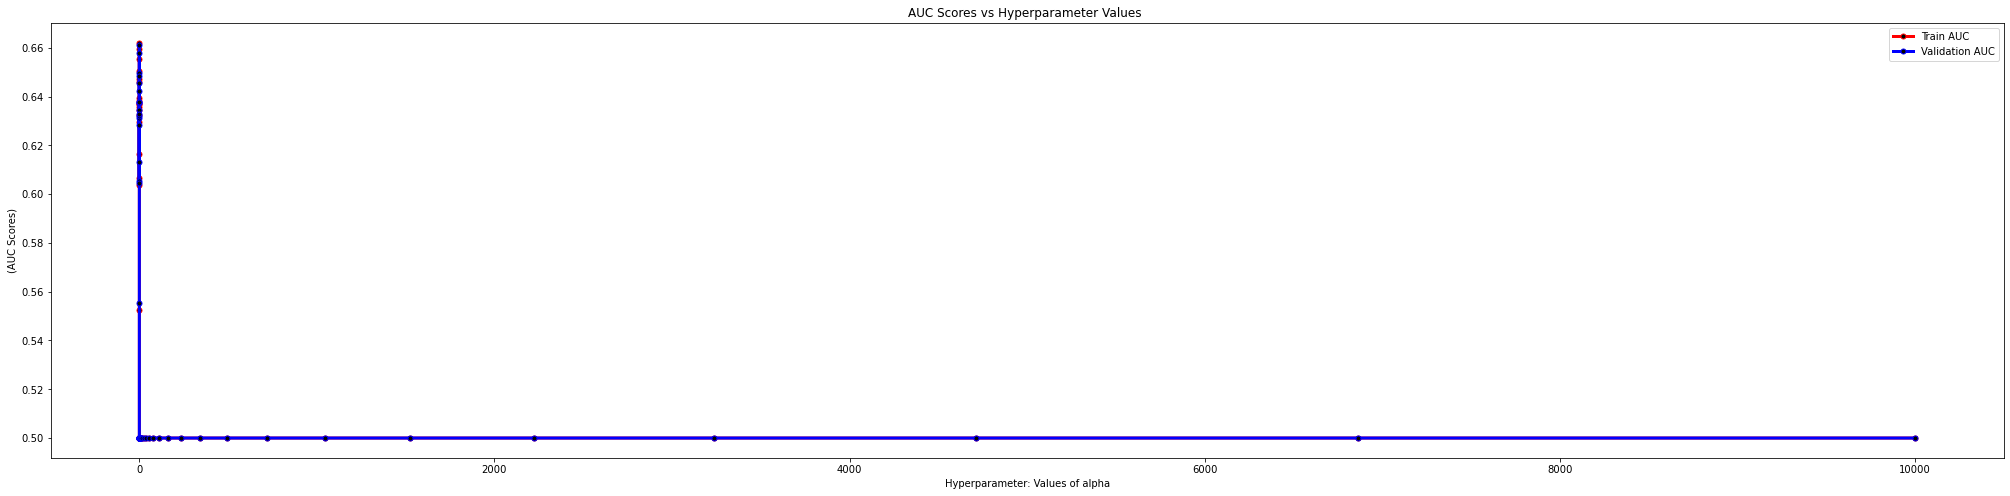

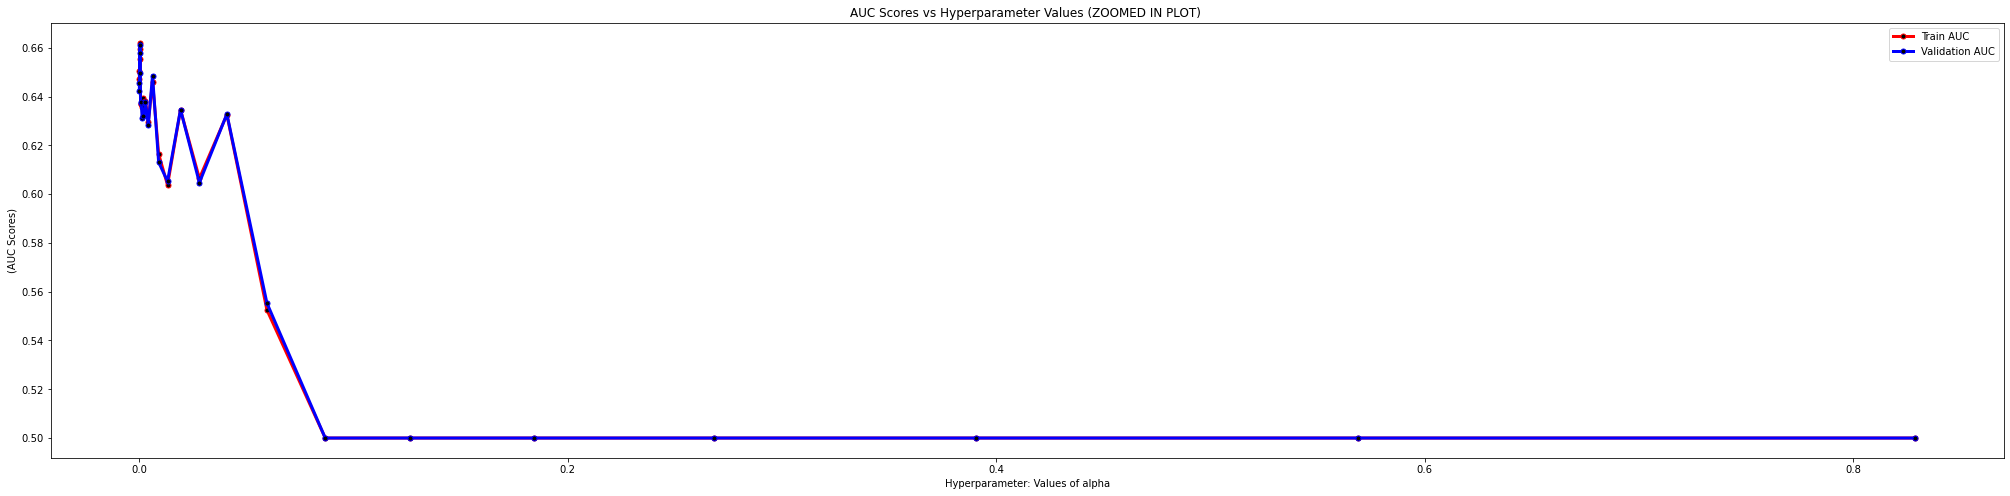


'''PERFORMANCE EVALUATION for TFIDF-W2V-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l1 regularization is 13842
Accuracy of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 73.9146686602232 %
Precision of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.5413
Recall of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.1198
F1 score of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.1961
AUC of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.6446

Clasification report 
              precision    recall  f1-score   support

           0       0.75      0.96      0.84     13751
           1       0.54      0.12      0.20      4976

    accuracy                           0.74     18727
   macro avg       0.65      0.54    

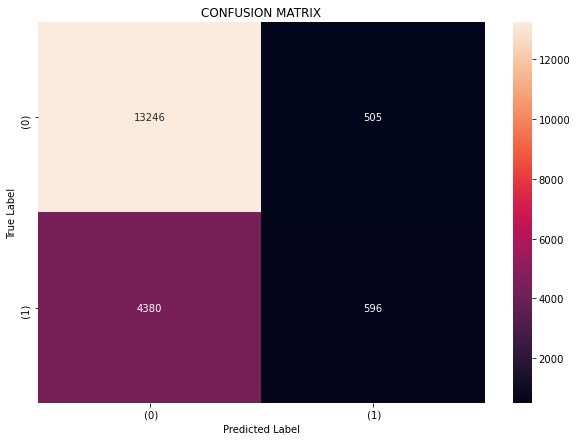

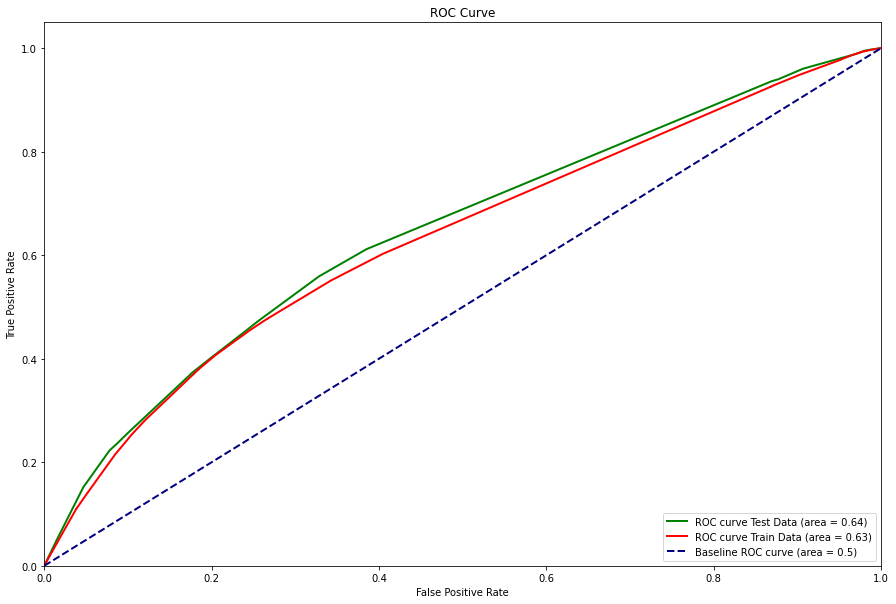

In [33]:
#Load the TF-IDF W2V Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
    
with open('X_train_TFIDF-W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('X_test_TFIDF-W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF-W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF-W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF-W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF-W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "TFIDF-W2V-LINEAR-SVM")

### [4.1.8] Applying Linear SVM on TFIDF W2V + L2 Regularization 


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for TFIDF-W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:00:37.278621
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.05963623316594643, random_state=0)
Best Score for l2 regularization :  0.6758906104663761
The optimal value of C using l1 regularization is : 0.05963623316594643


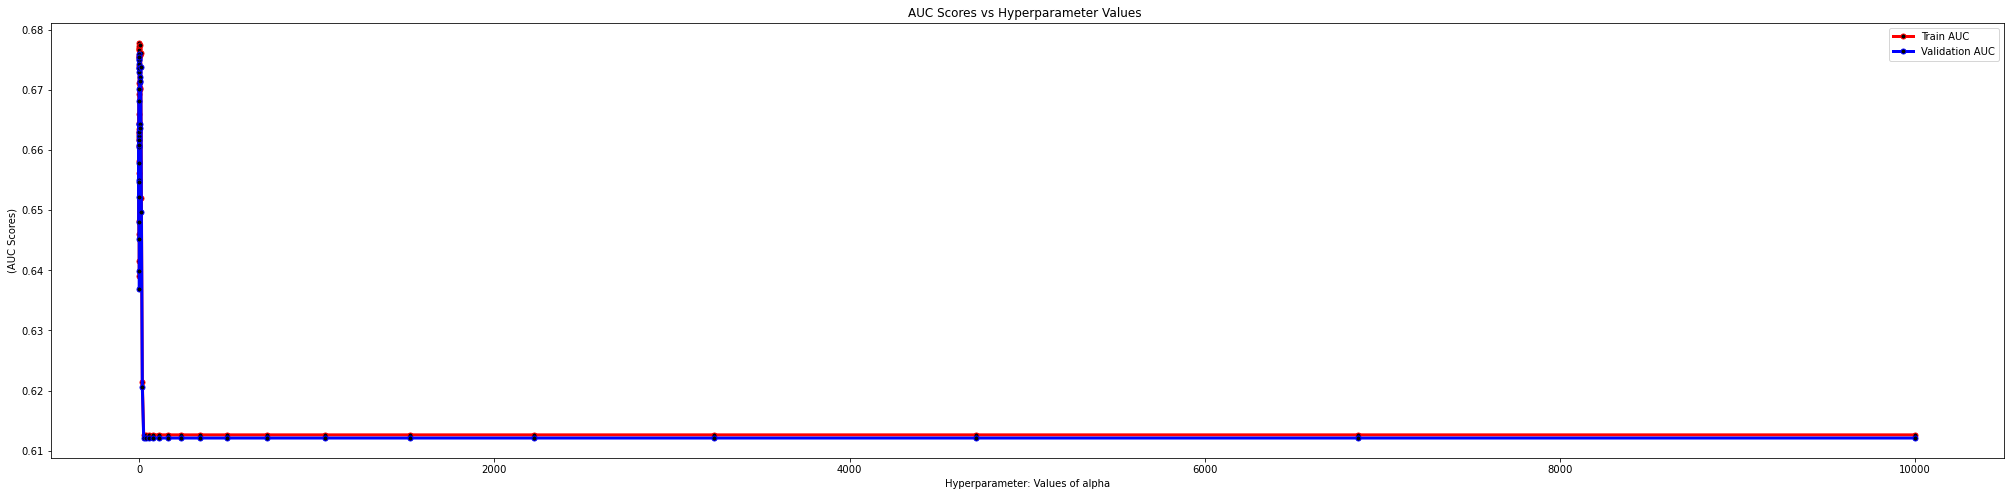

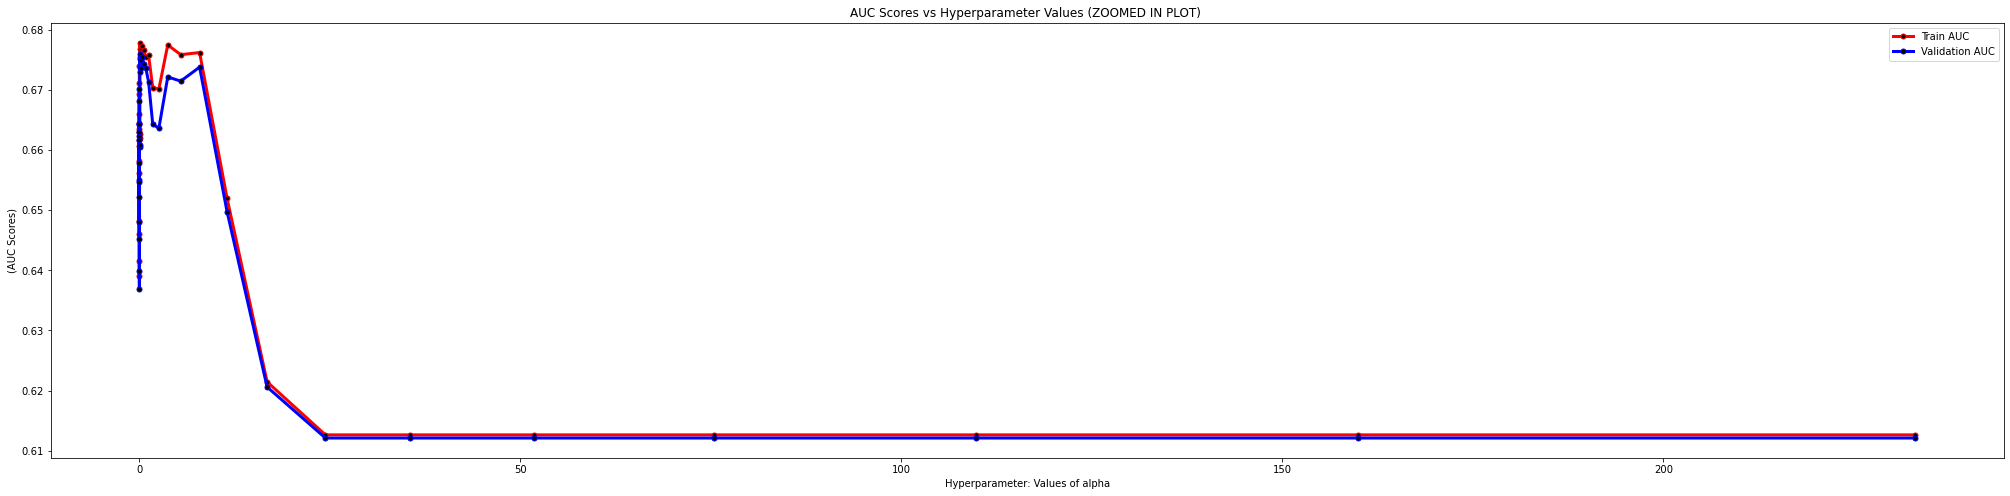


'''PERFORMANCE EVALUATION for TFIDF-W2V-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 18727 data points on unseen data for l2 regularization is 14016
Accuracy of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 74.84380840497677 %
Precision of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.6051
Recall of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.1533
F1 score of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.2447
AUC of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.6862

Clasification report 
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     13751
           1       0.61      0.15      0.24      4976

    accuracy                           0.75     18727
   macro avg       0.68      0.56   

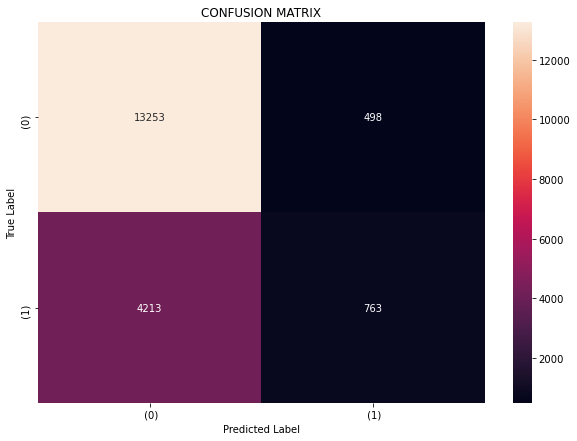

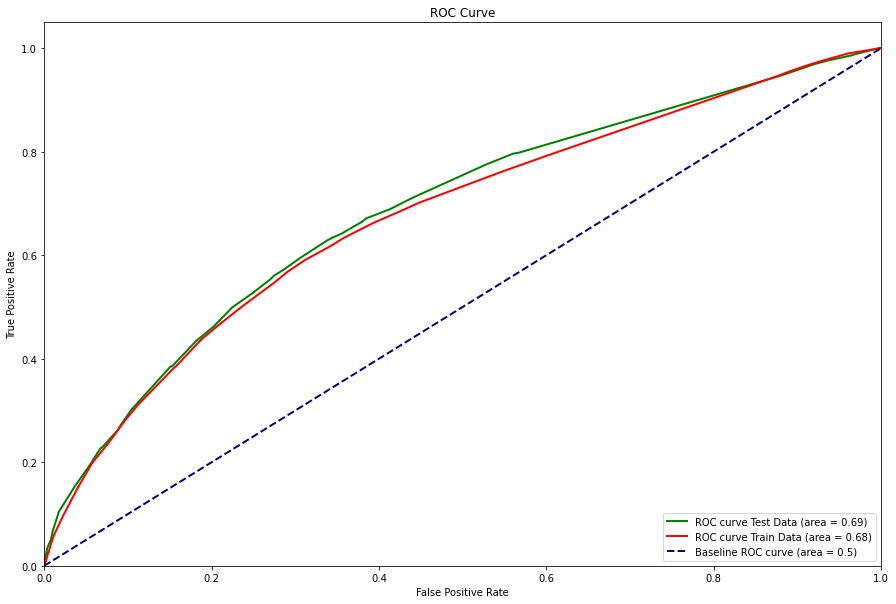

In [34]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "TFIDF-W2V-LINEAR-SVM")

## [6] Conclusions

In [40]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Regularization", " Hyper-Parameter Value (C=)", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_SVM.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table[7:15])

Please find below the important metrics for all the models below.

+----------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|        Model         | Regularization |  Hyper-Parameter Value (C=) | Accuracy on Unseen data | AUC Score | No. Of accurate predictions |
+----------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|    BOW-LINEAR-SVM    |       l1       |            0.002            |     78.4428899449992    |   0.7495  |            14690            |
|    BOW-LINEAR-SVM    |       l2       |            0.0063           |    81.12885139103967    |   0.8117  |            15193            |
|   TFIDF-LINEAR-SVM   |       l1       |            0.0043           |     78.8807603994233    |   0.7178  |            14772            |
|   TFIDF-LINEAR-SVM   |       l2       |            0.0043           |    78.85940086506115 

In [41]:
import pickle

In [42]:
# open a file, where you ant to store the data
file = open('svm_with_sgd_classifier_with_hinge_loss.pkl', 'wb')

# dump information to that file
pickle.dump(trained_classifier_BOW_LSVC_L2, file)